# 반도체 제조 공정 프로세스 Pass & Fail 수율 예측

## 분석 프로세스

### 데이터 전처리 과정  
반도체의 경우 불량인 반도체의 개수가 정상인 반도체보다 훨씬 적음  
이에 따라 Target Feature 불균형 문제가 발생하므로 이를 해소해야함  
(참고로 target 값이 -1인 것이 pass이고, 1인 것이 fail임)

### 데이터 정제 과정  
PCA를 통한 주성분 분석  
센서의 경우 이상치가 많이 발생하므로 이상치 제거 필요  

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 데이터 준비를 위한 EDA 및 전처리

### 데이터 불러오기  

In [2]:
# 필요한 파이썬 라이브러리 불러오기
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
data = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/07_ semiconductor_pass_fail_prediction/uci-secom.csv")
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
# 데이터의 모양 알아보기
data.shape

(1567, 592)

### 데이터 탐색

#### 데이터 타입

In [5]:
# 컬럼별 데이터 타입 알아보기
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


#### 데이터 통계값

In [6]:
# 컬럼별 간단한 통계값 보기
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


#### 결측값

In [7]:
data.isnull().any().any()     # True이면 결측값이 있다는 의미

True

#### 중복값

In [8]:
# 중복된 항목 수 알아보기
print("중복된 항목 수:", len(data[data.duplicated()]))

중복된 항목 수: 0


### 데이터 전처리

#### 결측값 채우기

In [9]:
# NaN을 0으로 채우기
data = data.replace(np.NaN, 0)

# 결측값 확인
data.isnull().any().any()

False

### Target Feature 정의

#### 데이터 탐색

In [10]:
data['Pass/Fail'].unique()

array([-1,  1])

> Pie Chart

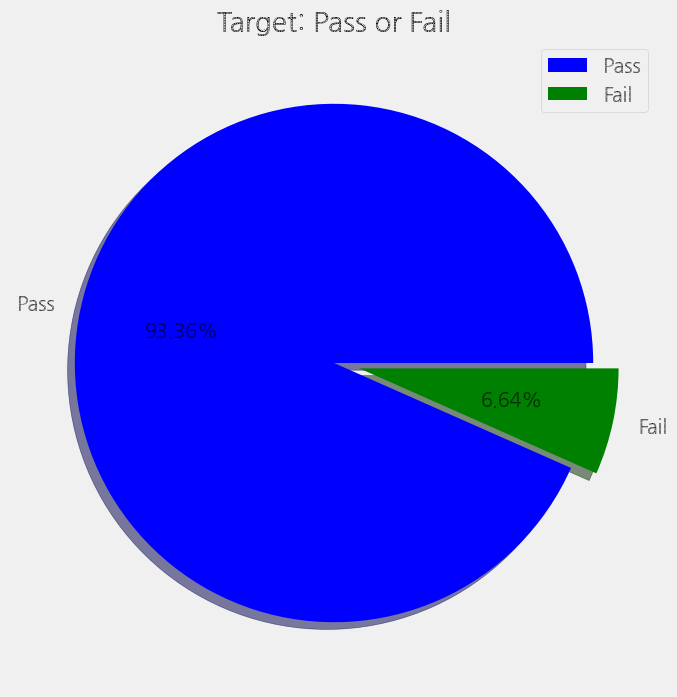

<Axes: >

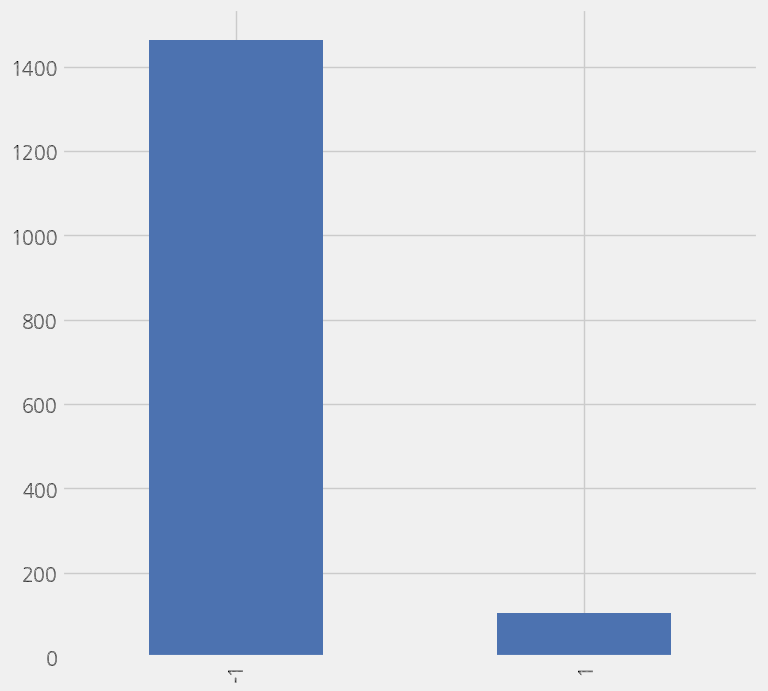

In [11]:
labels = ["Pass", "Fail"]
size = data["Pass/Fail"].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels=labels, colors=colors, explode=explode, autopct="%.2f%%", shadow=True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize=20)
plt.legend()
plt.show()

data['Pass/Fail'].value_counts().plot(kind="bar")

- 매우 불균형한 데이터

#### 각 센서별 Target Feature 분포

In [12]:
unique_vals = data['Pass/Fail'].unique()
# Pass와 Fail인 데이터 나눠서 탐색해보기
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

In [13]:
targets

[                     Time        0        1          2          3       4  \
 0     2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602   
 1     2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294   
 3     2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204   
 4     2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334   
 5     2008-07-19 17:53:00  2946.25  2432.84  2233.3667  1326.5200  1.5334   
 ...                   ...      ...      ...        ...        ...     ...   
 1562  2008-10-16 15:13:00  2899.41  2464.36  2179.7333  3085.3781  1.4843   
 1563  2008-10-16 20:49:00  3052.31  2522.55  2198.5667  1124.6595  0.8763   
 1564  2008-10-17 05:26:00  2978.81  2379.78  2206.3000  1110.4967  0.8236   
 1565  2008-10-17 06:01:00  2894.92  2532.01  2177.0333  1183.7287  1.5726   
 1566  2008-10-17 06:07:00  2944.92  2450.76  2195.4444  2914.1792  1.5978   
 
           5         6       7       8  ...       581     582 

<ipython-input-14-ab10efc6765a>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-14-ab10efc6765a>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-14-ab10efc6765a>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use e

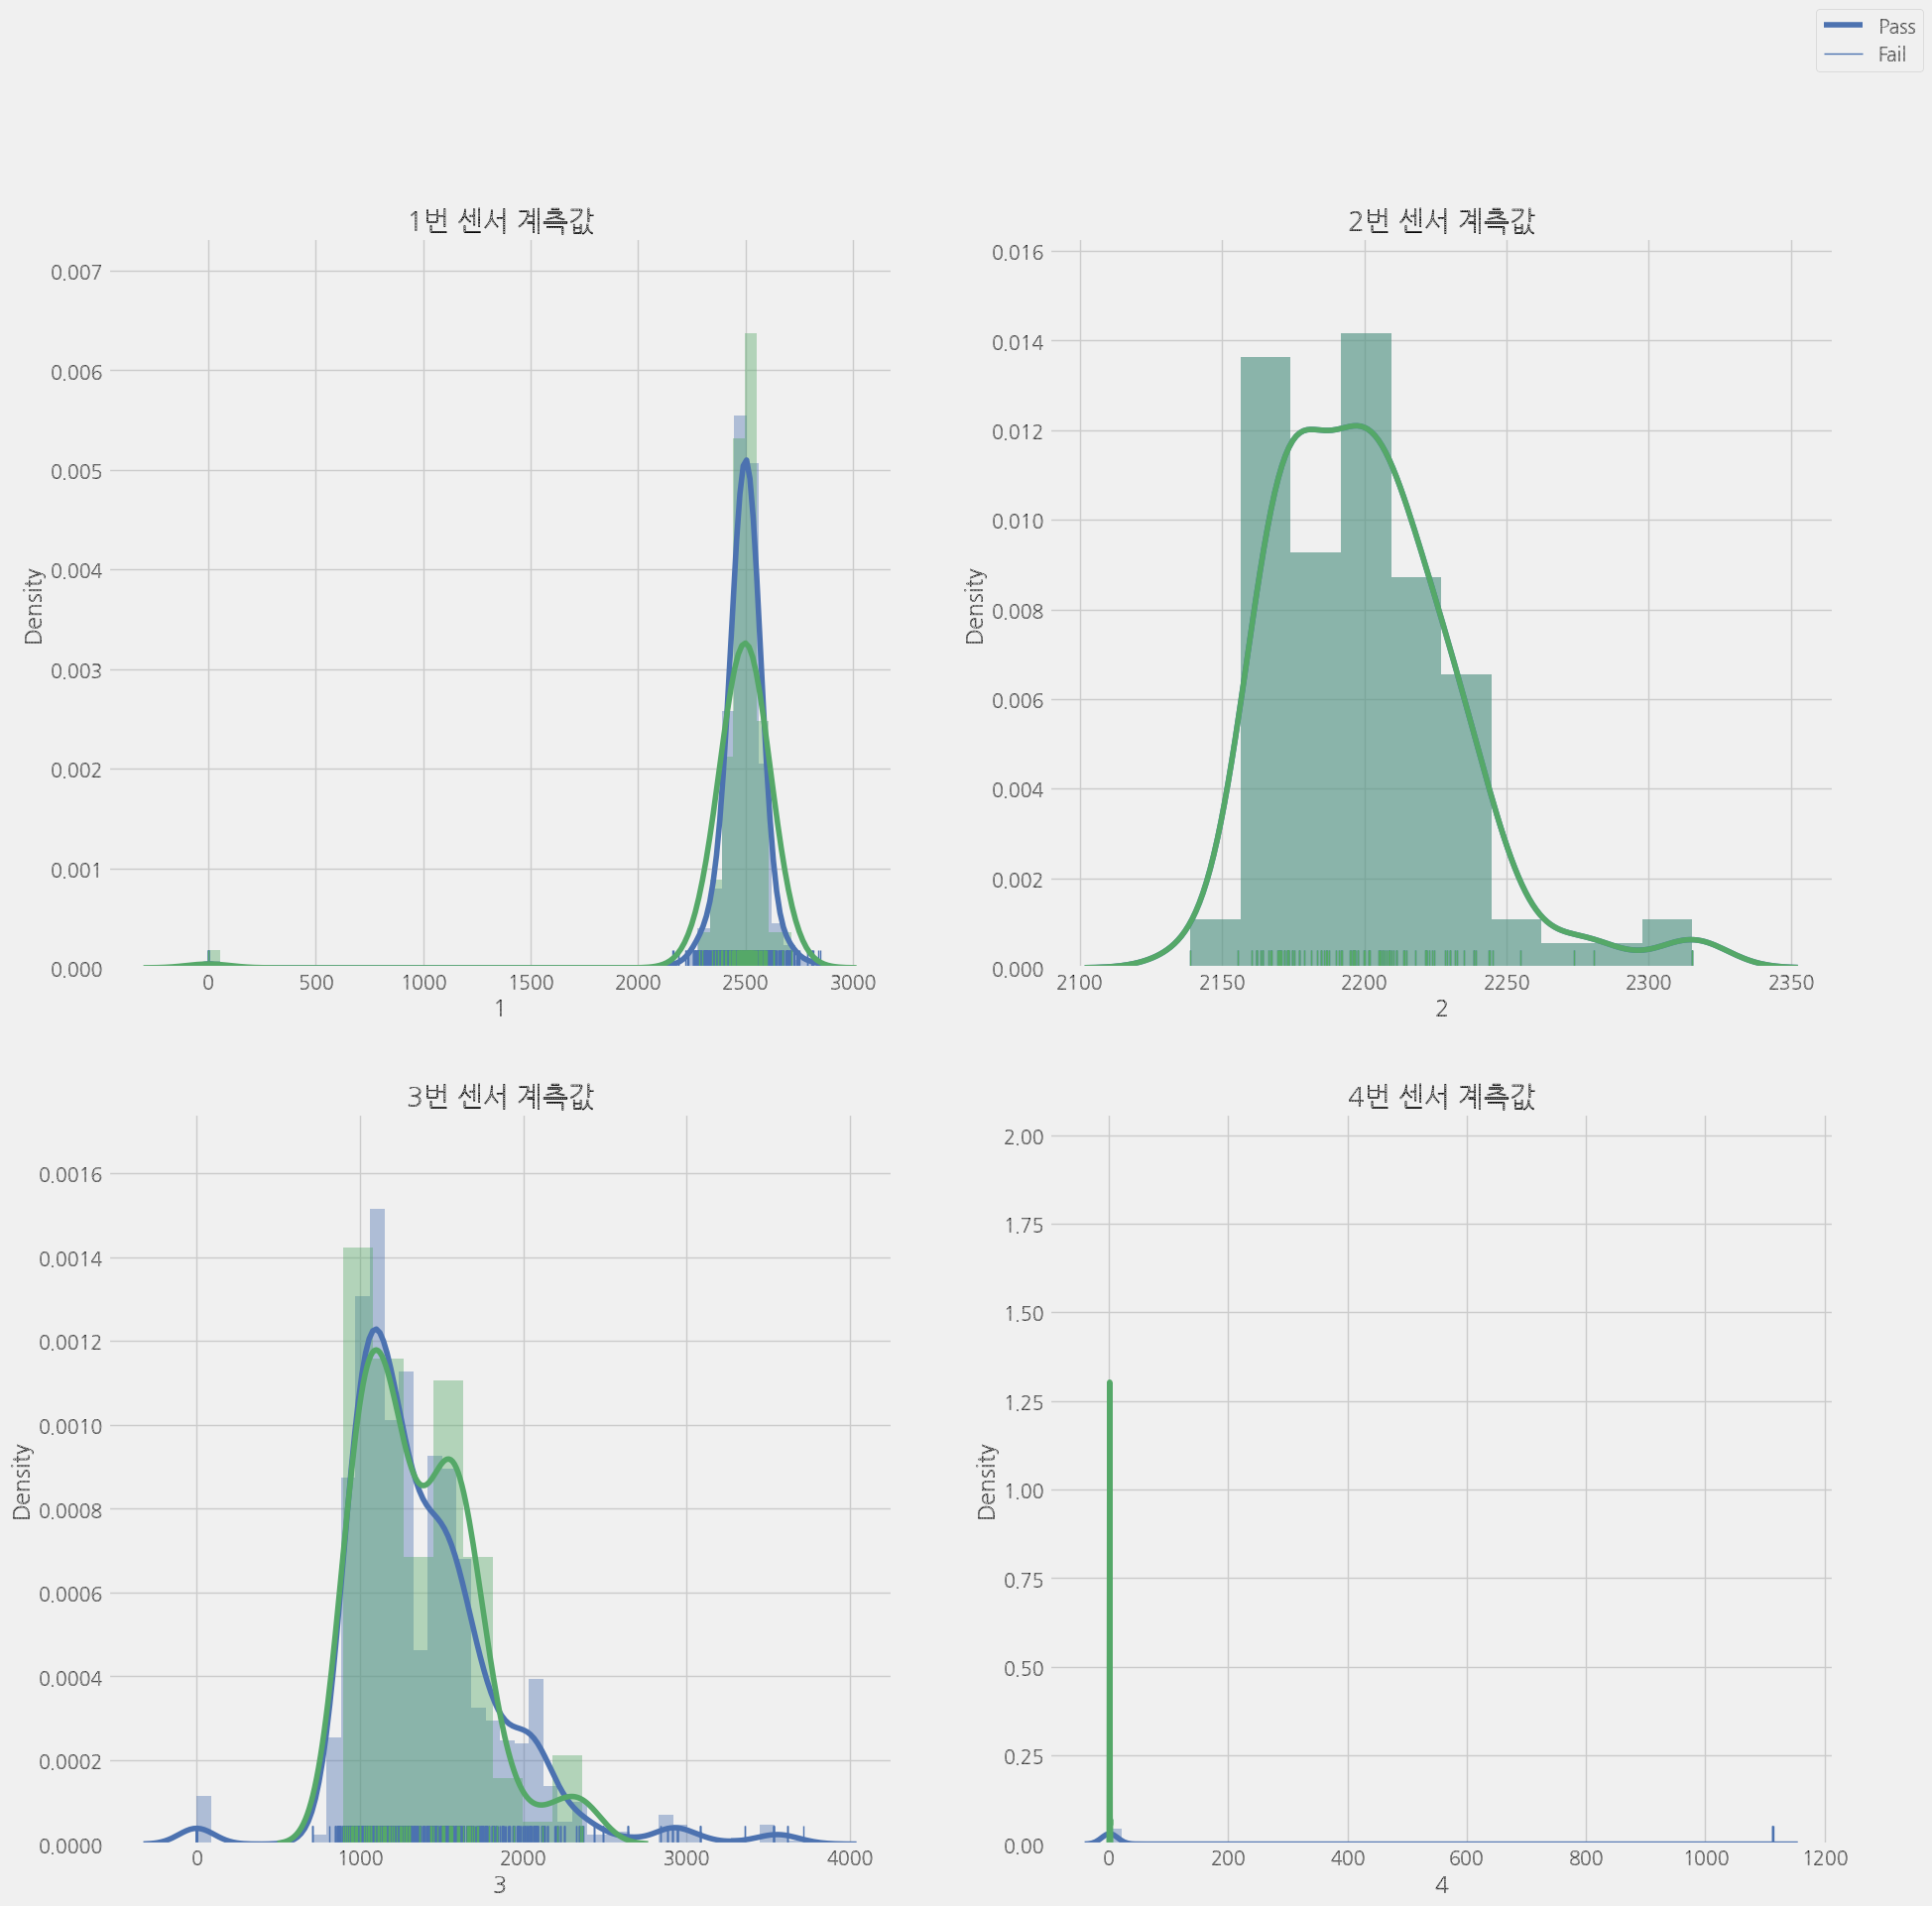

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

plt.subplot(2, 2, 1)
for target in targets:
  sns.distplot(target['1'], hist=True, rug=True)
plt.title('1번 센서 계측값', fontsize=20)

plt.subplot(2, 2, 2)
for taraget in targets:
  sns.distplot(target['2'], hist=True, rug=True)
plt.title('2번 센서 계측값', fontsize=20)

plt.subplot(2, 2, 3)
for target in targets:
  sns.distplot(target['3'], hist=True, rug=True)
plt.title('3번 센서 계측값', fontsize=20)

plt.subplot(2, 2, 4)
for target in targets:
  sns.distplot(target['4'], hist=True, rug=True)
plt.title('4번 센서 계측값', fontsize=20)

fig.legend(labels=['Pass', 'Fail'])
plt.show()

### 상관성에 따른 Feature정제

#### 히트맵 확인

<ipython-input-15-4a7dd08f7935>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



Text(0.5, 1.0, '상관 히트맵')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



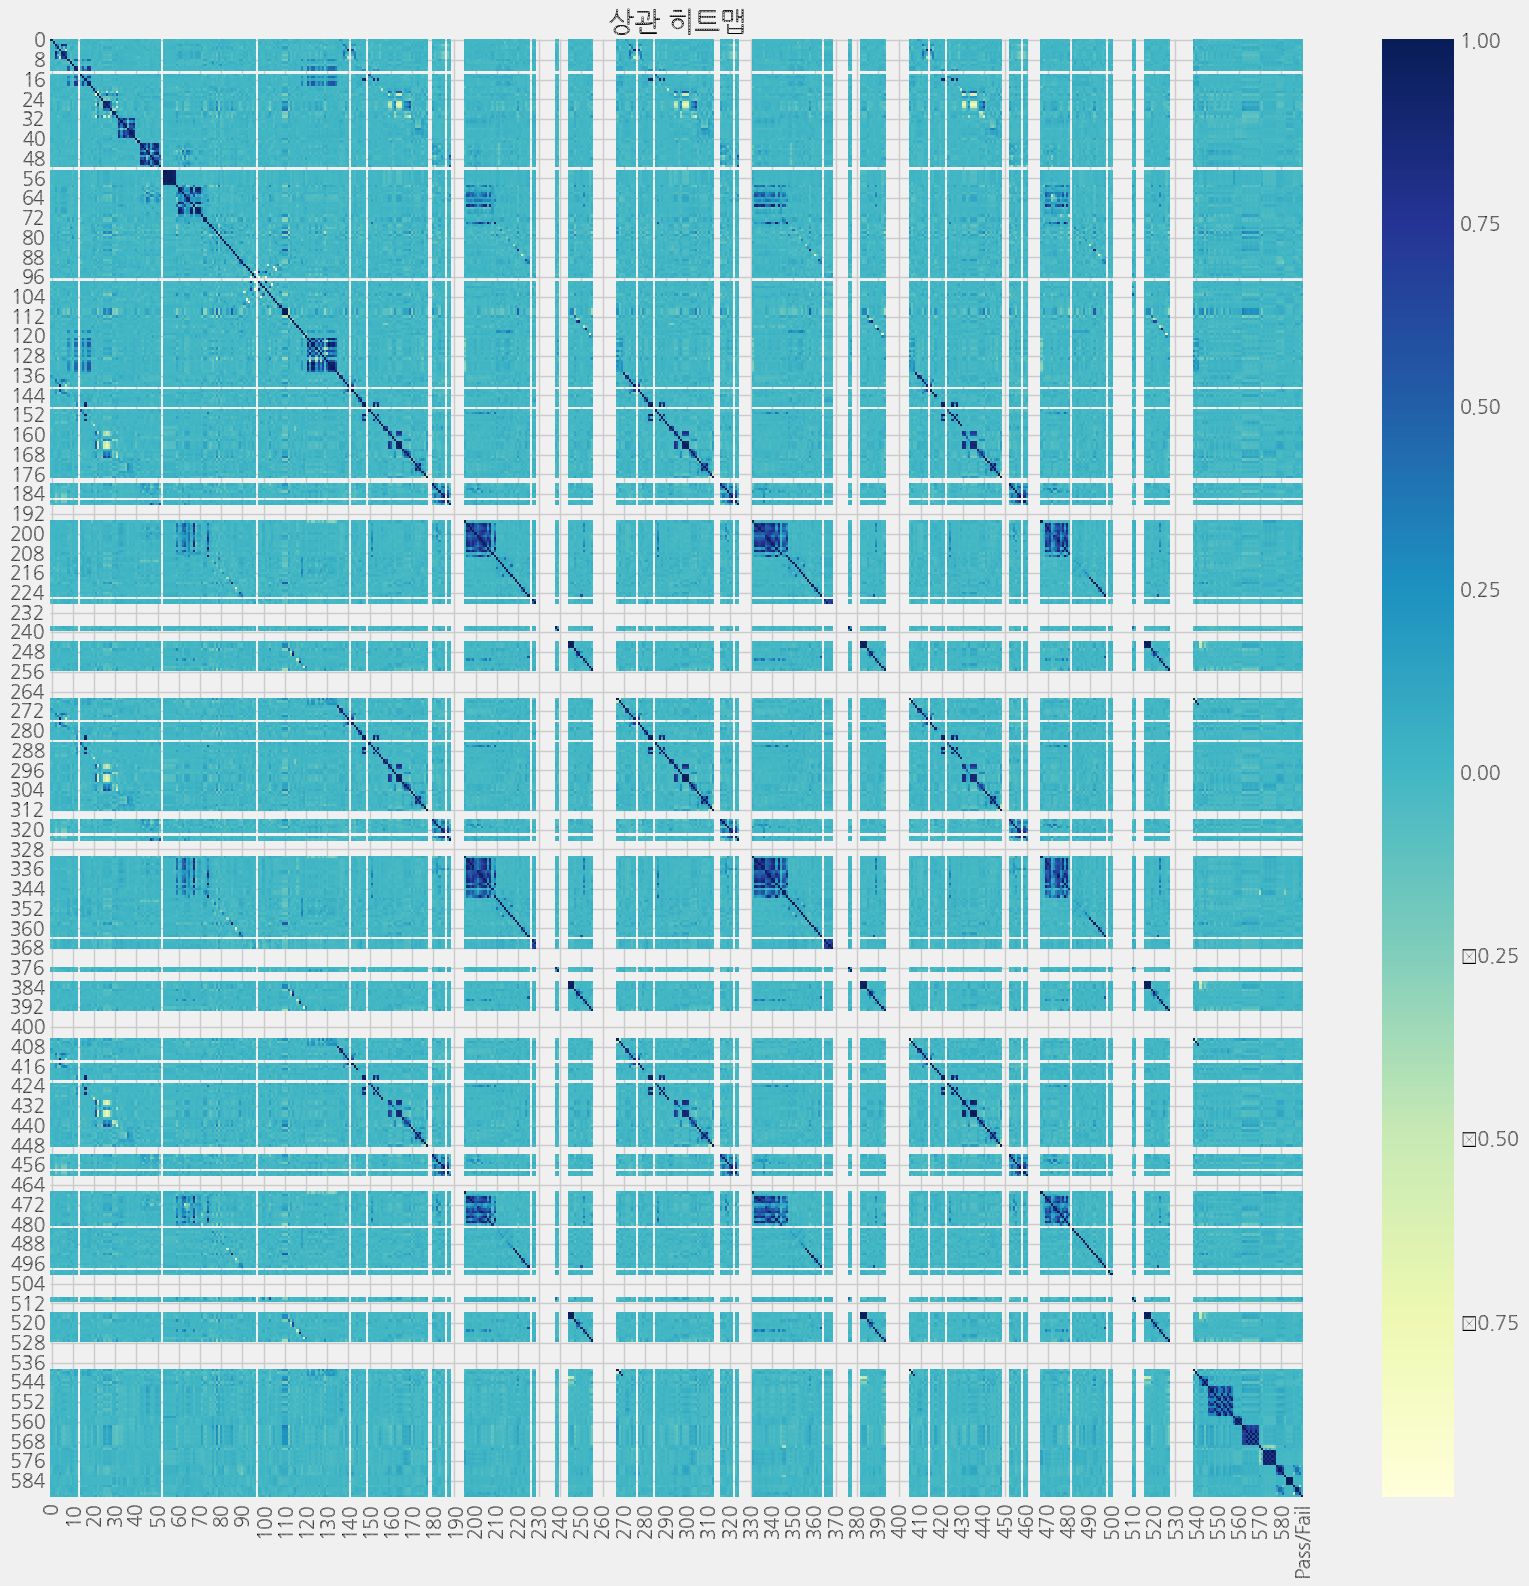

In [15]:
plt.rcParams['figure.figsize'] = (18, 18)

# Seaborn Heatmap 그려보기
sns.heatmap(data.corr(), cmap='YlGnBu')

plt.title('상관 히트맵', fontsize=20)

#### 상관 계수

상관 계수 필터링 함수  
> 입력한 상관계수 threshold에 따라 Feature를 필터링하는 함수 정의

In [16]:
# 상관계수 구하기
data.corr()

<ipython-input-16-6c7910c824c2>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,1.000000,-0.047782,0.007590,0.009448,-0.000915,0.008706,0.006129,0.010738,-0.050979,0.009959,...,-0.033622,0.010503,0.019840,0.017889,0.019522,0.044745,0.005233,0.003918,0.021489,0.006149
1,-0.047782,1.000000,-0.030448,0.006021,0.002192,-0.030127,-0.031616,-0.025086,0.027609,0.003704,...,0.043107,-0.017392,0.003809,0.004409,0.003821,-0.009219,0.039479,0.040500,0.044464,-0.019672
2,0.007590,-0.030448,1.000000,0.323782,0.020438,0.990089,0.818770,0.747230,0.002600,-0.045731,...,0.038416,-0.010627,-0.004771,-0.003030,-0.004263,0.015733,-0.007090,-0.009122,-0.030434,0.024929
3,0.009448,0.006021,0.323782,1.000000,-0.054015,0.286397,-0.119180,0.279646,-0.108217,0.051567,...,0.000922,0.009788,0.022593,0.022361,0.023288,0.038755,-0.038371,-0.033648,-0.084449,-0.016341
4,-0.000915,0.002192,0.020438,-0.054015,1.000000,0.007041,-0.034736,-0.475861,-0.020082,0.053859,...,0.107783,0.012778,-0.001323,-0.001605,-0.001636,-0.043693,-0.030930,-0.026046,0.050741,-0.013577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,0.044745,-0.009219,0.015733,0.038755,-0.043693,0.019435,-0.005877,0.051943,0.017642,0.032423,...,-0.206109,-0.008240,0.002391,0.001602,0.002872,1.000000,0.169634,0.165942,-0.484741,0.004448
587,0.005233,0.039479,-0.007090,-0.038371,-0.030930,-0.003077,0.016362,-0.006335,0.027655,0.057856,...,0.227096,0.018981,-0.001809,-0.001696,-0.002122,0.169634,1.000000,0.974332,0.391503,0.035670
588,0.003918,0.040500,-0.009122,-0.033648,-0.026046,-0.004919,0.013832,-0.014288,0.033729,0.059321,...,0.216292,0.019083,-0.001445,-0.001182,-0.001746,0.165942,0.974332,1.000000,0.389898,0.031447
589,0.021489,0.044464,-0.030434,-0.084449,0.050741,-0.026117,0.002246,-0.067263,-0.016895,0.004106,...,0.431632,0.028502,-0.002453,-0.002750,-0.003266,-0.484741,0.391503,0.389898,1.000000,-0.002472


In [17]:
def remove_collinear_features(x, threshold):
  # 데이터 프레임 x의 상관계수 구하기
  corr_matrix = x.corr()

  # Pass/Fail을 제외한 컬럼수
  iters = range(len(corr_matrix.columns) - 1)

  # 제거할 컬럼을 저장할 리스트
  drop_cols = []

  for i in iters:
    for j in range(i+1):
      # j행 (i+1)열 상관계수 가져오기
      item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
      # 상관계수 셀의 컬럼명 가져오기
      col = item.columns
      # 상관계수 셀의 인덱스 가져오기
      row = item.index
      # 상관 계수의 절대값
      val = abs(item.values)

      if val >= threshold:
        print(col.values[0], '열', row.values[0], '행의 상관계수:', round(val[0][0], 2))
        drop_cols.append(col.values[0])

  drops = set(drop_cols)
  x = x.drop(columns=drops)

  return x

In [18]:
threshold = 0.70
data = remove_collinear_features(data, threshold)

<ipython-input-17-f3c0f6af45b8>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



5 열 2 행의 상관계수: 0.99
6 열 2 행의 상관계수: 0.82
6 열 5 행의 상관계수: 0.84
7 열 2 행의 상관계수: 0.75
7 열 5 행의 상관계수: 0.77
12 열 11 행의 상관계수: 0.83
17 열 11 행의 상관계수: 0.81
18 열 11 행의 상관계수: 0.72
18 열 12 행의 상관계수: 0.79
18 열 17 행의 상관계수: 0.9
22 열 21 행의 상관계수: 0.75
26 열 25 행의 상관계수: 0.83
27 열 25 행의 상관계수: 0.98
27 열 26 행의 상관계수: 0.79
30 열 29 행의 상관계수: 0.86
34 열 32 행의 상관계수: 0.88
35 열 34 행의 상관계수: 0.83
37 열 32 행의 상관계수: 0.75
37 열 34 행의 상관계수: 0.75
38 열 32 행의 상관계수: 0.72
38 열 34 행의 상관계수: 0.72
38 열 36 행의 상관계수: 0.71
38 열 37 행의 상관계수: 0.97
39 열 32 행의 상관계수: 0.81
39 열 34 행의 상관계수: 0.91
39 열 35 행의 상관계수: 0.71
39 열 37 행의 상관계수: 0.86
39 열 38 행의 상관계수: 0.84
43 열 42 행의 상관계수: 0.82
44 열 42 행의 상관계수: 0.82
46 열 42 행의 상관계수: 0.84
46 열 43 행의 상관계수: 0.84
46 열 45 행의 상관계수: 0.74
48 열 44 행의 상관계수: 0.77
49 열 42 행의 상관계수: 1.0
49 열 43 행의 상관계수: 0.82
49 열 44 행의 상관계수: 0.82
49 열 46 행의 상관계수: 0.84
50 열 42 행의 상관계수: 0.88
50 열 43 행의 상관계수: 0.9
50 열 46 행의 상관계수: 0.97
50 열 49 행의 상관계수: 0.88
51 열 47 행의 상관계수: 0.71
54 열 53 행의 상관계수: 1.0
55 열 53 행의 상관계수: 0.95
55 열 54 행의 상관계수: 0.95
56

In [19]:
data.shape

(1567, 308)

#### 머신러닝 모델 입력 데이터 생성

In [20]:
# True 컬럼 삭제
data = data.drop(columns=['Time'], axis=1)

In [21]:
data.shape

(1567, 307)

In [22]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


### Target Feature 불균형 문제 처리

#### UnderSampling
> 데이터 탐색

In [23]:
# 결과가 fail인 데이터 개수
failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [24]:
# 결과가 pass인 데이터 개수
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [25]:
# Pass 라벨 (값이 1)에서 랜덤으로 104개 가져오기
random_normal_indices = np.random.choice(no_normal_indices, size=no_failed_tests, replace=True)
random_normal_indices = np.array(random_normal_indices )

print(len(random_normal_indices))

104


In [26]:
# 같은 비율로 합친 Pass/Fail 데이터 생성
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [27]:
undersample_data = data.iloc[under_sample, :]
undersample_data

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.2100,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
10,2994.05,2548.21,2195.1222,1046.1468,1.3204,1.5144,-0.0190,0.0013,0.9433,0.0,...,532.1764,1.8715,9.5699,0.0355,0.4925,0.0158,0.0355,0.0205,57.8122,1
11,2928.84,2479.40,2196.2111,1605.7578,0.9959,1.4690,0.0170,-0.0154,0.9445,0.0,...,533.7464,2.1865,7.7400,0.0370,0.4987,0.0427,0.0370,0.0279,75.5077,1
14,2963.97,2629.48,2224.6222,947.7739,1.2924,1.4474,0.0144,-0.0119,0.9582,0.0,...,532.6446,2.2808,11.4200,0.0202,0.5077,0.0094,0.0202,0.0289,142.9080,1
23,2884.74,2514.54,2160.3667,899.9488,1.4022,1.5585,-0.0317,-0.0138,0.9638,0.0,...,536.0054,1.9902,8.7600,0.0098,0.4982,0.0099,0.0098,0.0213,216.8869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,2942.41,2523.71,2207.0444,1269.6078,1.7571,1.5272,0.0181,0.0022,0.9519,0.0,...,534.8673,2.1953,8.7300,0.0000,0.5017,0.0161,0.0235,0.0355,150.7761,1
111,3039.57,2583.78,2197.8445,1907.8909,1.1799,1.5847,0.0283,0.0118,0.9668,0.0,...,533.3509,2.1114,8.0900,0.0000,0.4987,0.0184,0.0139,0.0139,99.4503,-1
298,3032.29,2356.94,2218.5778,1632.2734,0.8396,1.3526,-0.0040,-0.0105,0.9708,0.0,...,533.2600,2.5306,8.2600,0.0277,0.4988,0.0152,0.0277,0.0087,31.4497,-1
1241,2871.62,2530.11,2175.2556,1022.1660,1.2833,1.4679,-0.0033,-0.0022,0.9630,0.0,...,529.9445,1.9740,7.9100,0.0283,0.5012,0.0131,0.0283,0.0112,39.4516,1


In [28]:
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail']
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']
y = y.replace(-1, 0)

print(x.shape)
print(y.shape)

(208, 306)
(208, 1)


In [29]:
# 언더 샘플링 데이터 훈련 / 테스트 데이터 분할
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size=0.3, random_state=1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [30]:
# StandardScaler 적용

sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

#### OverSampling using SMOTE

In [31]:
y.values.ravel()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [32]:
# SMOTE 적용
x_resample, y_resample = SMOTE(random_state=1).fit_resample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(224, 306)
(224,)


In [33]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state=1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [34]:
# StandardScale 적용
sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

## 머신러닝 모델링

### 데이터 준비

In [35]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [36]:
x = data.iloc[:, :(data.shape[1] -1)]
y = data['Pass/Fail'].replace(-1, 0)

print("shape of x: ", x.shape)
print("shape of y: ", y.shape)

shape of x:  (1567, 306)
shape of y:  (1567,)


In [37]:
# 훈련 / 테스트 데이터 세트 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

print("shape of x_train:", x_train.shape)
print("shape of x_test:", x_test.shape)
print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)

shape of x_train: (1096, 306)
shape of x_test: (471, 306)
shape of y_train: (1096,)
shape of y_test: (471,)


### 다양한 Classifier와 Grid Search를 활용한 최적 모델 탐색

#### Feature Scaling

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#### XGBoost (Scaled 데이터)

In [39]:
xg = XGBClassifier(random_state=1)
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)

> Confusion Matrix

<Axes: >

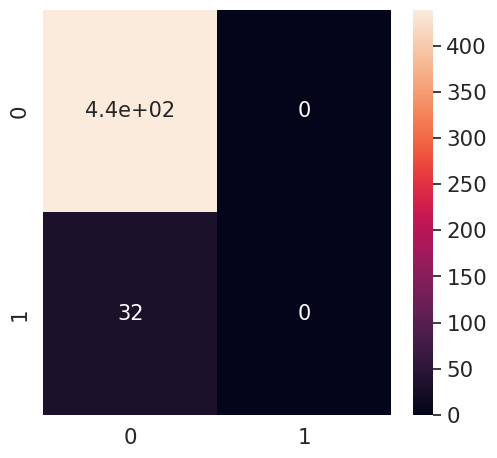

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [41]:
print("Accuracy:", xg.score(x_test, y_test) * 100)

Accuracy: 93.20594479830149


#### RandomForest (Scaled 데이터)

In [42]:
# RandomForest 모델링
rf = RandomForestClassifier(n_estimators=10, random_state=1, verbose=0)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

> Confusion Matrix

<Axes: >

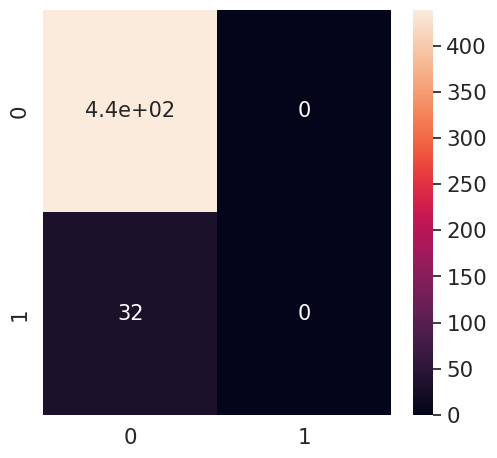

In [43]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [44]:
print("Accuracy:", rf.score(x_test, y_test) * 100)

Accuracy: 93.20594479830149


#### Logistic Regression (Scaled 데이터)

In [45]:
# Logistic Regression 생성
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

> Confusion Matrix

<Axes: >

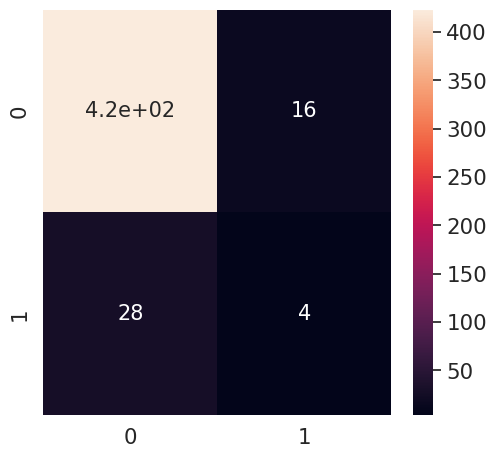

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [47]:
print("Accuracy:", lr.score(x_test, y_test) * 100)

Accuracy: 90.65817409766454


#### Lasso (Scaled 데이터)

In [48]:
lasso = Lasso(alpha=0.1, random_state=1)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)

In [49]:
# 예측값의 부호를 classifier로 변환
y_pred2 = np.around(y_pred)

In [50]:
print("Accuracy:", lasso.score(x_test, y_test) * 100)

Accuracy: -0.007974076019090504


> Confusion Matrix

<Axes: >

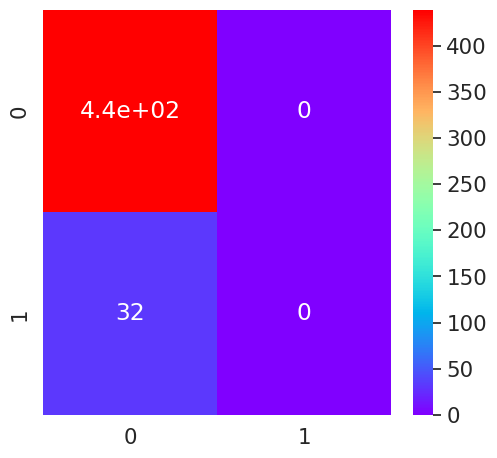

In [51]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='rainbow')

### 언더샘플링 데이터 대상 재모델링

#### XGBoost (Undersampled 데이터)

In [52]:
model = XGBClassifier(random_state=1)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

> Confusion Matrix

<Axes: >

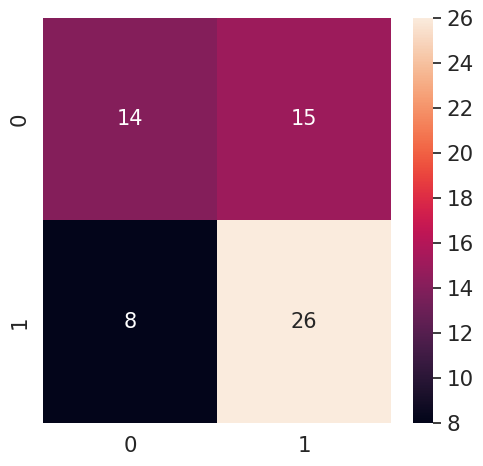

In [53]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [54]:
# 기존 데이터는 한 쪽으로 데이터가 90프로 이상 몰려있었기 떄문에 학습이 잘 안되고 다수의 target으로 무조건 예측해도 Accuracy가 90을 넘음
# 현재 사용한 데이터는 타겟을 50:50으로 나눈 것이므로 Accuracy가 50을 넘으면 임의의 결과보다는 낫게 학습된 것이라고 볼 수 있음
print("Accuracy", model.score(x_test, y_test) * 100)

Accuracy 27.176220806794056


#### Grid Search - XGBoost (Undersampled 데이터)

In [55]:
parameters = [({'max_depth': [1, 2, 3, 4, 5, 6],
                'cv': [2, 4, 6, 8, 10],
                'random_state': [1]})]

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', n_jobs=-1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cv" } are not used.




In [56]:
print("Best Accuracy:", best_accuracy * 100)
print("Best Parameter:", best_parameters)

Best Accuracy: 68.9655172413793
Best Parameter: {'cv': 2, 'max_depth': 5, 'random_state': 1}


In [57]:
# scale_pos_weights 사용
weights = (y == 0).sum()/(1.0*(y == -1).sum())

model = XGBClassifier(max_depth=3, scale_pos_weights=weights, n_jobs=4, random_state=1, cv=2)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

<ipython-input-57-5d2cdfa16c0a>:2: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cv", "scale_pos_weights" } are not used.




In [58]:
print("Accuracy:", model.score(x_test_us, y_test_us) * 100)

Accuracy: 60.317460317460316


> Confusion Matrix

<Axes: >

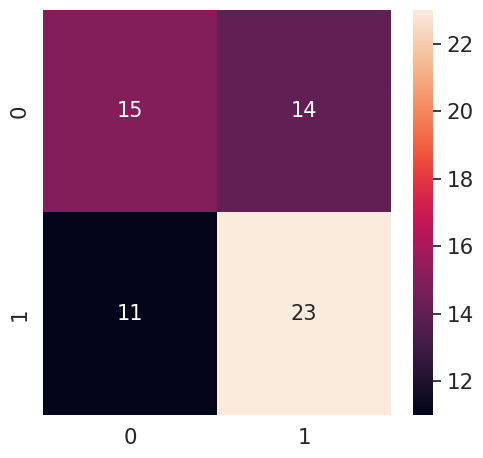

In [59]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

#### Random Forest (Undersampled 데이터)

In [60]:
model = RandomForestClassifier(n_estimators=100, random_state=1, verbose=0)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

<ipython-input-60-ca2907b9b5a8>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



> Confusion Matrix

<Axes: >

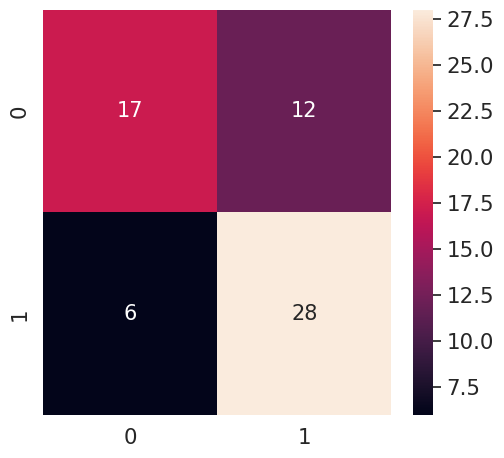

In [61]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [62]:
print("Accuracy:", model.score(x_test_us, y_test_us) * 100)

Accuracy: 71.42857142857143


#### Logistic Regression (Undersampled 데이터)

In [63]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(random_state=1)

In [64]:
y_pred = lr.predict(x_test_us)

> Confusion Matrix

<Axes: >

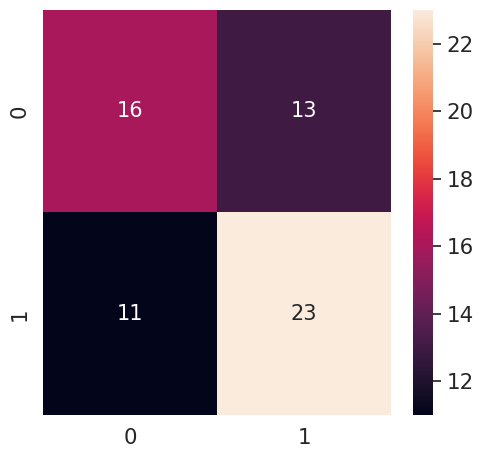

In [65]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [66]:
print("Accuracy:", lr.score(x_test_us, y_test_us) * 100)

Accuracy: 61.904761904761905


#### Lasso (Undersampled 데이터)

In [67]:
lasso = Lasso(alpha=0.1, random_state=1)
lasso.fit(x_train_us, y_train_us)

Lasso(alpha=0.1, random_state=1)

In [68]:
y_pred = lasso.predict(x_test_us)

In [69]:
print(y_pred)

[0.43842967 0.6077574  0.3899217  0.5804214  0.57535184 0.56650661
 0.59333585 0.56269534 0.5371464  0.5486063  0.57417631 0.58379529
 0.52339533 0.56940726 0.57892402 0.51232929 0.57439276 0.43784052
 0.62434839 0.53489931 0.53887206 0.53913255 0.60977109 0.54617408
 0.5859239  0.44181129 0.52865696 0.61158827 0.62279746 0.46869534
 0.45730935 0.51520386 0.60491258 0.57435051 0.5147521  0.44327898
 0.58827058 0.57805009 0.51184627 0.49714221 0.47245756 0.54844531
 0.54457536 0.59781549 0.53848191 0.54143544 0.56709002 0.52915909
 0.50744644 0.52140995 0.55141416 0.53784392 0.53585483 0.56827255
 0.54259866 0.44067131 0.63540355 0.505513   0.4691774  0.55052251
 0.57958579 0.61114669 0.59098992]


In [70]:
print(y_test_us)

      Pass/Fail
1142          0
116           0
996           0
344           1
495           1
...         ...
1302          1
273           1
600           0
380           0
441           1

[63 rows x 1 columns]


In [71]:
y_pred2 = np.around(y_pred)

> Confusion Matrix

<Axes: >

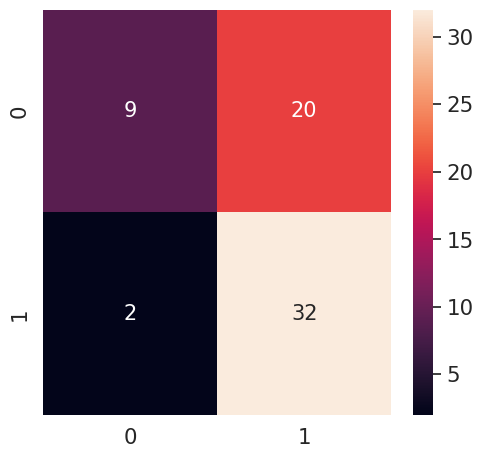

In [72]:
cm = confusion_matrix(y_test_us, y_pred2)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

### 오버샘플링 데이터 대상 재모델링

#### Grid Search - XGBoost (Oversampled 데이터)

In [73]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

In [74]:
from sklearn.model_selection import GridSearchCV

parameters = [({'max_depth': [1, 2, 3, 4, 5, 6],
                'cv': [2, 4, 6, 8, 10],
                'random_state': [1]})]

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', n_jobs=-1)
grid_search = grid_search.fit(x_train_os, y_train_os)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cv" } are not used.




In [75]:
print("Best Accuracy:", best_accuracy * 100)
print("Best Parameter:", best_parameters)

Best Accuracy: 68.9655172413793
Best Parameter: {'cv': 2, 'max_depth': 5, 'random_state': 1}


In [76]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())

model = XGBClassifier(max_depth=3, scale_pos_weights=weights, n_jobs=4, random_state=1, cv=2)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

<ipython-input-76-61f590cf1dd1>:1: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cv", "scale_pos_weights" } are not used.




> Confusion Matrix

<Axes: >

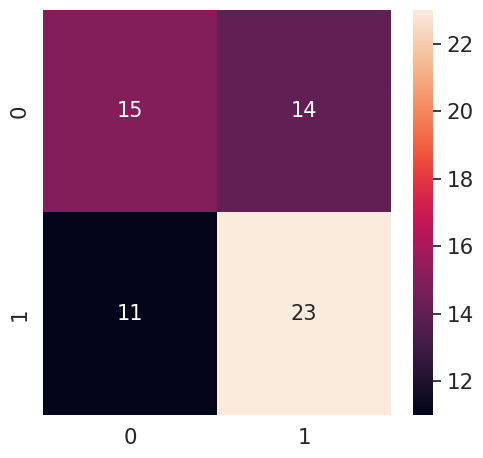

In [77]:
cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

In [78]:
print("Accuracy:", model.score(x_test_os, y_test_os) * 100)

Accuracy: 60.317460317460316


#### Random Forest (Oversampled 데이터)

In [79]:
model = RandomForestClassifier(n_estimators=100, random_state=1, verbose=0)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

<ipython-input-79-ddeb6df2a9c0>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



> Confusion Matrix

<Axes: >

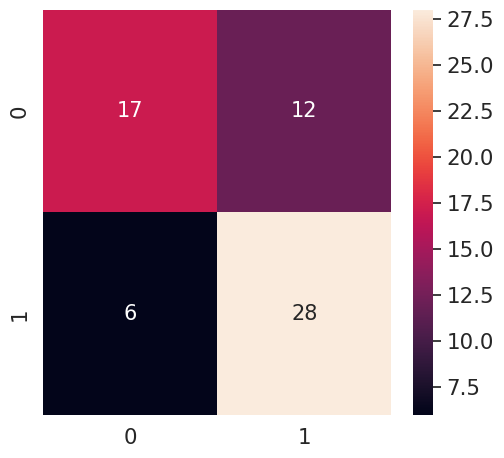

In [80]:
cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

#### Logistic Regression (Oversampled 데이터)

In [81]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_os, y_train_os)
y_pred = lr.predict(x_test_os)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [82]:
print("Accuracy:", lr.score(x_test_os, y_test_os) * 100)

Accuracy: 61.904761904761905


> Confusion Matrix

<Axes: >

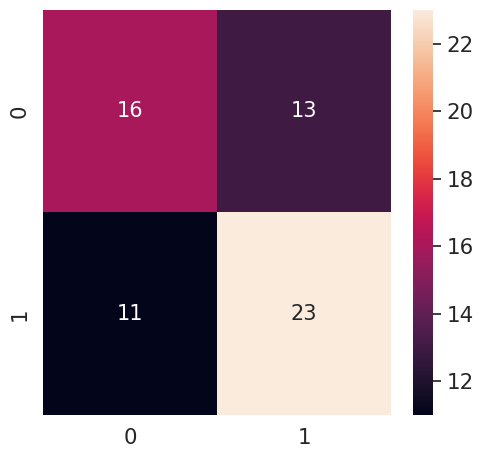

In [83]:
cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15})

### PCA를 활용한 차원 축소

In [84]:
data.shape

(1567, 307)

In [85]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


#### Scaling using zscore

In [86]:
from scipy.stats import zscore
data_new = data.iloc[:, :306].apply(zscore)
data_new.head()

,0,1,2,3,4,8,9,10,11,13,...,565,570,571,572,578,582,583,586,587,589
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.436850,1.128343,-0.381523,-0.481360,NaN,...,-1.305710,0.190142,0.034410,-0.226018,-0.662093,0.055275,-0.204269,-1.734706,-1.868461,-1.061159
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.393723,0.022511,-1.608226,-0.011526,NaN,...,-1.305710,0.256816,1.205944,-0.261137,0.083539,0.162312,0.407145,-0.958144,0.412587,1.156951
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,-0.192349,0.327111,0.124224,-0.044305,NaN,...,5.447531,0.257279,-0.263745,-0.199823,3.873831,-0.304064,0.022827,2.989383,3.624211,-0.178407
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.300837,-0.765478,-0.370762,-0.006063,NaN,...,0.464315,0.002548,-0.278290,-0.221613,0.906840,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.465600,-0.149655,-0.790424,-0.169959,NaN,...,-1.305710,0.085279,-0.270290,-0.227409,-0.662093,-1.512057,26.860983,-0.100689,-0.177535,-0.274469


In [89]:
# 결측치 확인
data_new.isnull().any().any()

True

In [91]:
# 결측치 0으로 대체
data_new = data_new.replace(np.NaN, 0)

In [92]:
data_new.isnull().any().any()

False

In [95]:
x = data_new.iloc[:, :306]
y = data['Pass/Fail'].replace(-1, 0)

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


#### PCA Step1 - Convariance Matrix 만들기

In [102]:
# x의 covariance matrix 만들기
cov_matrix = np.cov(x.T)
print('Covariance Matrix \n', cov_matrix)

Covariance Matrix 
 [[ 1.00063857 -0.04781282  0.00759455 ...  0.04477373  0.00523674
   0.02150242]
 [-0.04781282  1.00063857 -0.03046719 ... -0.00922529  0.03950455
   0.04449214]
 [ 0.00759455 -0.03046719  1.00063857 ...  0.01574304 -0.00709495
  -0.03045388]
 ...
 [ 0.04477373 -0.00922529  0.01574304 ...  1.00063857  0.16974222
  -0.48505059]
 [ 0.00523674  0.03950455 -0.00709495 ...  0.16974222  1.00063857
   0.39175294]
 [ 0.02150242  0.04449214 -0.03045388 ... -0.48505059  0.39175294
   1.00063857]]


#### PCA Step2 - Eigen Values와 Eigen Vector 만들기

In [103]:
# eigne values, eigen vectors 만들기
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

print("Eigen Vectors \n", eig_vecs)
print("\nEigen Values \n", eig_vals)

Eigen Vectors 
 [[-0.0253695   0.008654   -0.00303277 ...  0.          0.
   0.        ]
 [-0.0025788  -0.00538507 -0.03440905 ...  0.          0.
   0.        ]
 [ 0.02753407 -0.00681287 -0.01400105 ...  0.          0.
   0.        ]
 ...
 [-0.048536    0.05395333 -0.04823939 ...  0.          0.
   0.        ]
 [ 0.01242541 -0.02265625  0.00838096 ...  0.          0.
   0.        ]
 [ 0.0256921  -0.06086426  0.04287574 ...  0.          0.
   0.        ]]

Eigen Values 
 [7.98315826 4.02662836 3.83340365 3.77872193 3.24842052 3.04338189
 2.81987221 2.70184859 2.63844411 2.49433697 2.39544185 2.33496444
 2.2688959  2.21004546 2.11987395 2.18253643 2.06331064 2.02389709
 2.01071359 1.99863763 1.98267329 1.95915582 1.92095551 1.8898469
 1.85708597 1.83222209 1.79047783 1.77162466 1.74830769 1.69223045
 1.6721054  1.59353955 1.61120278 1.64351825 1.63509768 1.58746461
 1.54878319 1.54342972 1.51376615 1.4987913  1.39927034 1.42330375
 1.46908609 1.45916185 1.45031371 1.37348926 1.36548073 

In [105]:
tot = sum(eig_vals)
var_exp = [( i / tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("누적 분산 설명력", cum_var_exp)      # 결과 리스트의 list[i] 값은 변수 i개를 썼을 때의 전체에 대해 list[i] 퍼센트 만큼 설명이 가능하다는 의미

누적 분산 설명력 [  4.11240397   6.18666104   8.16138131  10.10793312  11.78130812
  13.34906055  14.80167533  16.19349202  17.55264684  18.83756703
  20.07154289  21.27436472  22.44315234  23.58162404  24.70592487
  25.79794607  26.86082953  27.90340969  28.93919857  29.96876671
  30.99011105  31.99934072  32.98889207  33.96241829  34.91906821
  35.86290988  36.78524762  37.69787343  38.59848786  39.47021494
  40.3315749   41.17820862  42.02050462  42.85049151  43.67137946
  44.48913799  45.28697037  46.08204499  46.86183886  47.63391867
  48.39069629  49.14236158  49.88946889  50.62266242  51.3434755
  52.05100785  52.75441472  53.44575446  54.13150394  54.80518611
  55.47224219  56.13386282  56.78335336  57.43035818  58.06247379
  58.68657041  59.30627663  59.91402001  60.51888826  61.11881541
  61.71313647  62.30277087  62.88054936  63.45680398  64.02642122
  64.58794689  65.14526769  65.69372362  66.23286709  66.7660594
  67.29318433  67.81743689  68.33600263  68.84838165  69.35881173
  

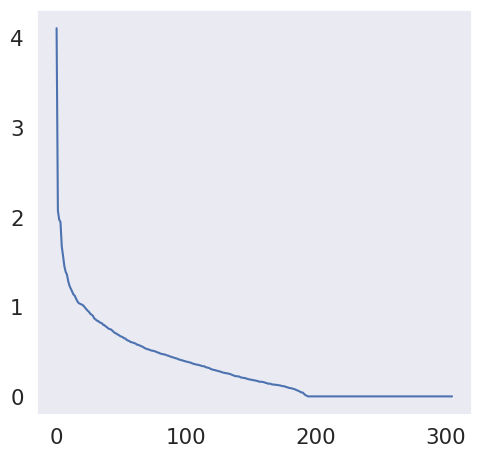

In [106]:
plt.plot(var_exp)

> Explained Variance Ration: 각각의 주성분 벡터가 이루는 축에 투영(projection)한 결과의 분산의 비율 (=각 eigenvalue의 비율)

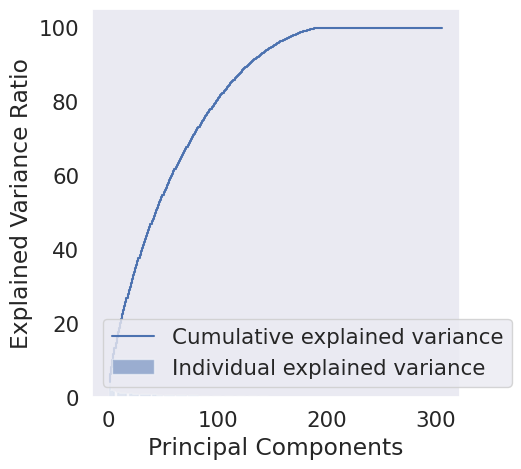

In [108]:
# Ploting plt.figure(figsize=(10, 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [109]:
len(cum_var_exp)

306

#### Scikit-learn으로 PCA 적용하기

In [110]:
from sklearn.decomposition import PCA

# x에 PCA 적용하기 (n_components=130)
pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[ 3.26184535e+00,  1.81271503e+00,  2.21584037e+00, ...,
        -5.38608077e+00, -4.57166559e+00, -5.28922167e+00],
       [ 8.02592999e-02,  8.46266119e-01,  2.62132600e-01, ...,
         3.48972205e+01,  4.06189914e+00,  3.53853720e+01],
       [-2.10894363e-01, -9.59759823e-01, -1.19302193e+00, ...,
         3.05894417e+00,  2.00047506e+00,  5.14339556e+00],
       ...,
       [ 6.24782391e-02,  1.56100269e+00,  1.52295051e+00, ...,
        -1.17931369e+00, -1.52958190e+00, -9.00176171e-02],
       [-4.31625772e-01,  4.66836410e-01,  8.79056710e-01, ...,
        -1.47083207e+00,  4.05438510e-02, -3.85943298e-01],
       [ 8.11663598e-03, -3.78382763e-01, -1.25067247e+00, ...,
        -2.95198678e-02, -1.18695358e+00,  1.12396483e+00]])

In [111]:
 pca.components_

array([[-0.0253695 , -0.00257883,  0.02753403, ..., -0.04853599,
         0.01242541,  0.02569209],
       [-0.00865434,  0.00538447,  0.00681067, ..., -0.05395147,
         0.02265628,  0.06086395],
       [-0.00303459, -0.03440952, -0.01400111, ..., -0.04823792,
         0.00838174,  0.0428745 ],
       ...,
       [ 0.00510738, -0.04061683,  0.03560557, ..., -0.00649034,
        -0.06166067,  0.04861806],
       [-0.06040155,  0.01588114, -0.02595117, ...,  0.06232066,
         0.11621714, -0.03312256],
       [-0.08106698, -0.11142373,  0.01007769, ..., -0.12424184,
        -0.09596531,  0.0792441 ]])

In [112]:
df_comp = pd.DataFrame(pca.components_, columns=list(x))
df_comp.head()

,0,1,2,3,4,8,9,10,11,13,...,565,570,571,572,578,582,583,586,587,589
0,-0.025370,-0.002579,0.027534,-0.066608,-0.024699,0.077981,-0.031003,0.017991,-0.011328,2.462499e-20,...,-0.103563,-0.017317,0.095065,-0.020350,-0.006380,-0.012915,0.006665,-0.048536,0.012425,0.025692
1,-0.008654,0.005384,0.006811,0.043186,0.000094,-0.217420,0.002424,0.042955,-0.307619,1.725256e-18,...,0.013687,-0.015341,0.029585,0.013741,0.039332,0.006929,0.006353,-0.053951,0.022656,0.060864
2,-0.003035,-0.034410,-0.014001,-0.003740,-0.003485,-0.062296,-0.011085,-0.037445,-0.033602,1.596464e-19,...,-0.032973,-0.007391,-0.011181,-0.008240,-0.029706,-0.048940,0.013380,-0.048238,0.008382,0.042875
3,-0.011013,0.019494,0.031017,0.008149,0.037434,0.027086,-0.034176,0.030430,0.011600,3.607387e-19,...,0.042445,-0.031512,-0.018139,0.031904,0.048761,0.010022,0.018018,0.021470,-0.018804,-0.007799
4,-0.001613,-0.024108,-0.050003,-0.037779,-0.031001,0.003805,-0.003772,-0.000667,-0.092512,9.528625e-18,...,-0.051724,-0.022407,0.033654,0.025763,-0.102889,-0.021627,-0.015483,0.035709,-0.088354,-0.083101


<Axes: >

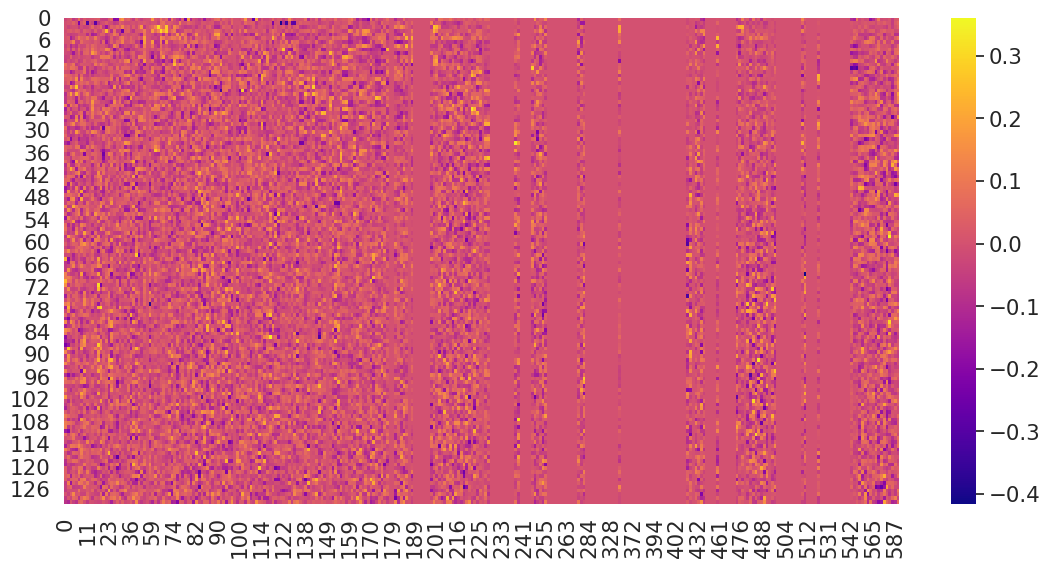

In [116]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_comp, cmap='plasma')

> PCA 적용된 데이터 탐색

In [114]:
data_reduced.shape

(1567, 130)

In [115]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,3.261845,0.080259,-0.210894,-0.872020,-0.619143,0.753713,-0.013541,-0.573107,-3.189414,1.890731,...,0.597011,0.129799,0.163919,-1.236091,-0.928972,1.286382,0.595113,0.062478,-0.431626,0.008117
1,1.812715,0.846266,-0.959760,-0.070889,0.165308,0.658406,-1.083386,0.302425,-2.560083,1.300792,...,0.672093,-0.100437,1.150088,-0.630985,0.034853,-0.892983,-0.842436,1.561003,0.466836,-0.378383
2,2.215840,0.262133,-1.193022,2.265412,-1.239456,-0.950923,2.024561,0.907192,-1.154030,-1.810408,...,-0.506619,-0.327261,0.623591,0.198543,-0.025534,0.438596,-0.770978,1.522951,0.879057,-1.250672
3,3.617123,0.816392,-0.817325,2.152177,-2.613065,-1.410007,1.172524,0.840984,-0.293070,-2.762278,...,-1.107562,1.894585,-2.795294,-2.794580,4.061021,-2.023804,0.099786,-2.240592,-0.160927,0.119188
4,2.765982,0.133659,1.444815,2.270278,-1.497668,-0.623732,-2.928785,-1.896251,2.506257,1.484144,...,0.048576,0.648038,-0.803855,-0.505483,1.166455,0.210237,-1.372093,-0.440587,0.498821,0.108911


> Pass/Fail 데이터 합치기

In [124]:
df_red3 = df_red2.copy()
df_red4 = df_red3
df_red4['Pass/Fail'] = data['Pass/Fail'].replace(-1, 0)

In [125]:
df_red4.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,Pass/Fail
0,3.261845,0.080259,-0.210894,-0.872020,-0.619143,0.753713,-0.013541,-0.573107,-3.189414,1.890731,...,0.129799,0.163919,-1.236091,-0.928972,1.286382,0.595113,0.062478,-0.431626,0.008117,0
1,1.812715,0.846266,-0.959760,-0.070889,0.165308,0.658406,-1.083386,0.302425,-2.560083,1.300792,...,-0.100437,1.150088,-0.630985,0.034853,-0.892983,-0.842436,1.561003,0.466836,-0.378383,0
2,2.215840,0.262133,-1.193022,2.265412,-1.239456,-0.950923,2.024561,0.907192,-1.154030,-1.810408,...,-0.327261,0.623591,0.198543,-0.025534,0.438596,-0.770978,1.522951,0.879057,-1.250672,1
3,3.617123,0.816392,-0.817325,2.152177,-2.613065,-1.410007,1.172524,0.840984,-0.293070,-2.762278,...,1.894585,-2.795294,-2.794580,4.061021,-2.023804,0.099786,-2.240592,-0.160927,0.119188,0
4,2.765982,0.133659,1.444815,2.270278,-1.497668,-0.623732,-2.928785,-1.896251,2.506257,1.484144,...,0.648038,-0.803855,-0.505483,1.166455,0.210237,-1.372093,-0.440587,0.498821,0.108911,0


In [126]:
df_red4.shape

(1567, 131)

#### 이상치 제거

> Pass/Fail 별 PCA 데이터의 이상치 탐색

array([[<Axes: title={'center': '0'}, xlabel='Pass/Fail'>,
        <Axes: title={'center': '1'}, xlabel='Pass/Fail'>],
       [<Axes: title={'center': '2'}, xlabel='Pass/Fail'>,
        <Axes: title={'center': '3'}, xlabel='Pass/Fail'>],
       [<Axes: title={'center': '4'}, xlabel='Pass/Fail'>,
        <Axes: title={'center': '5'}, xlabel='Pass/Fail'>]], dtype=object)

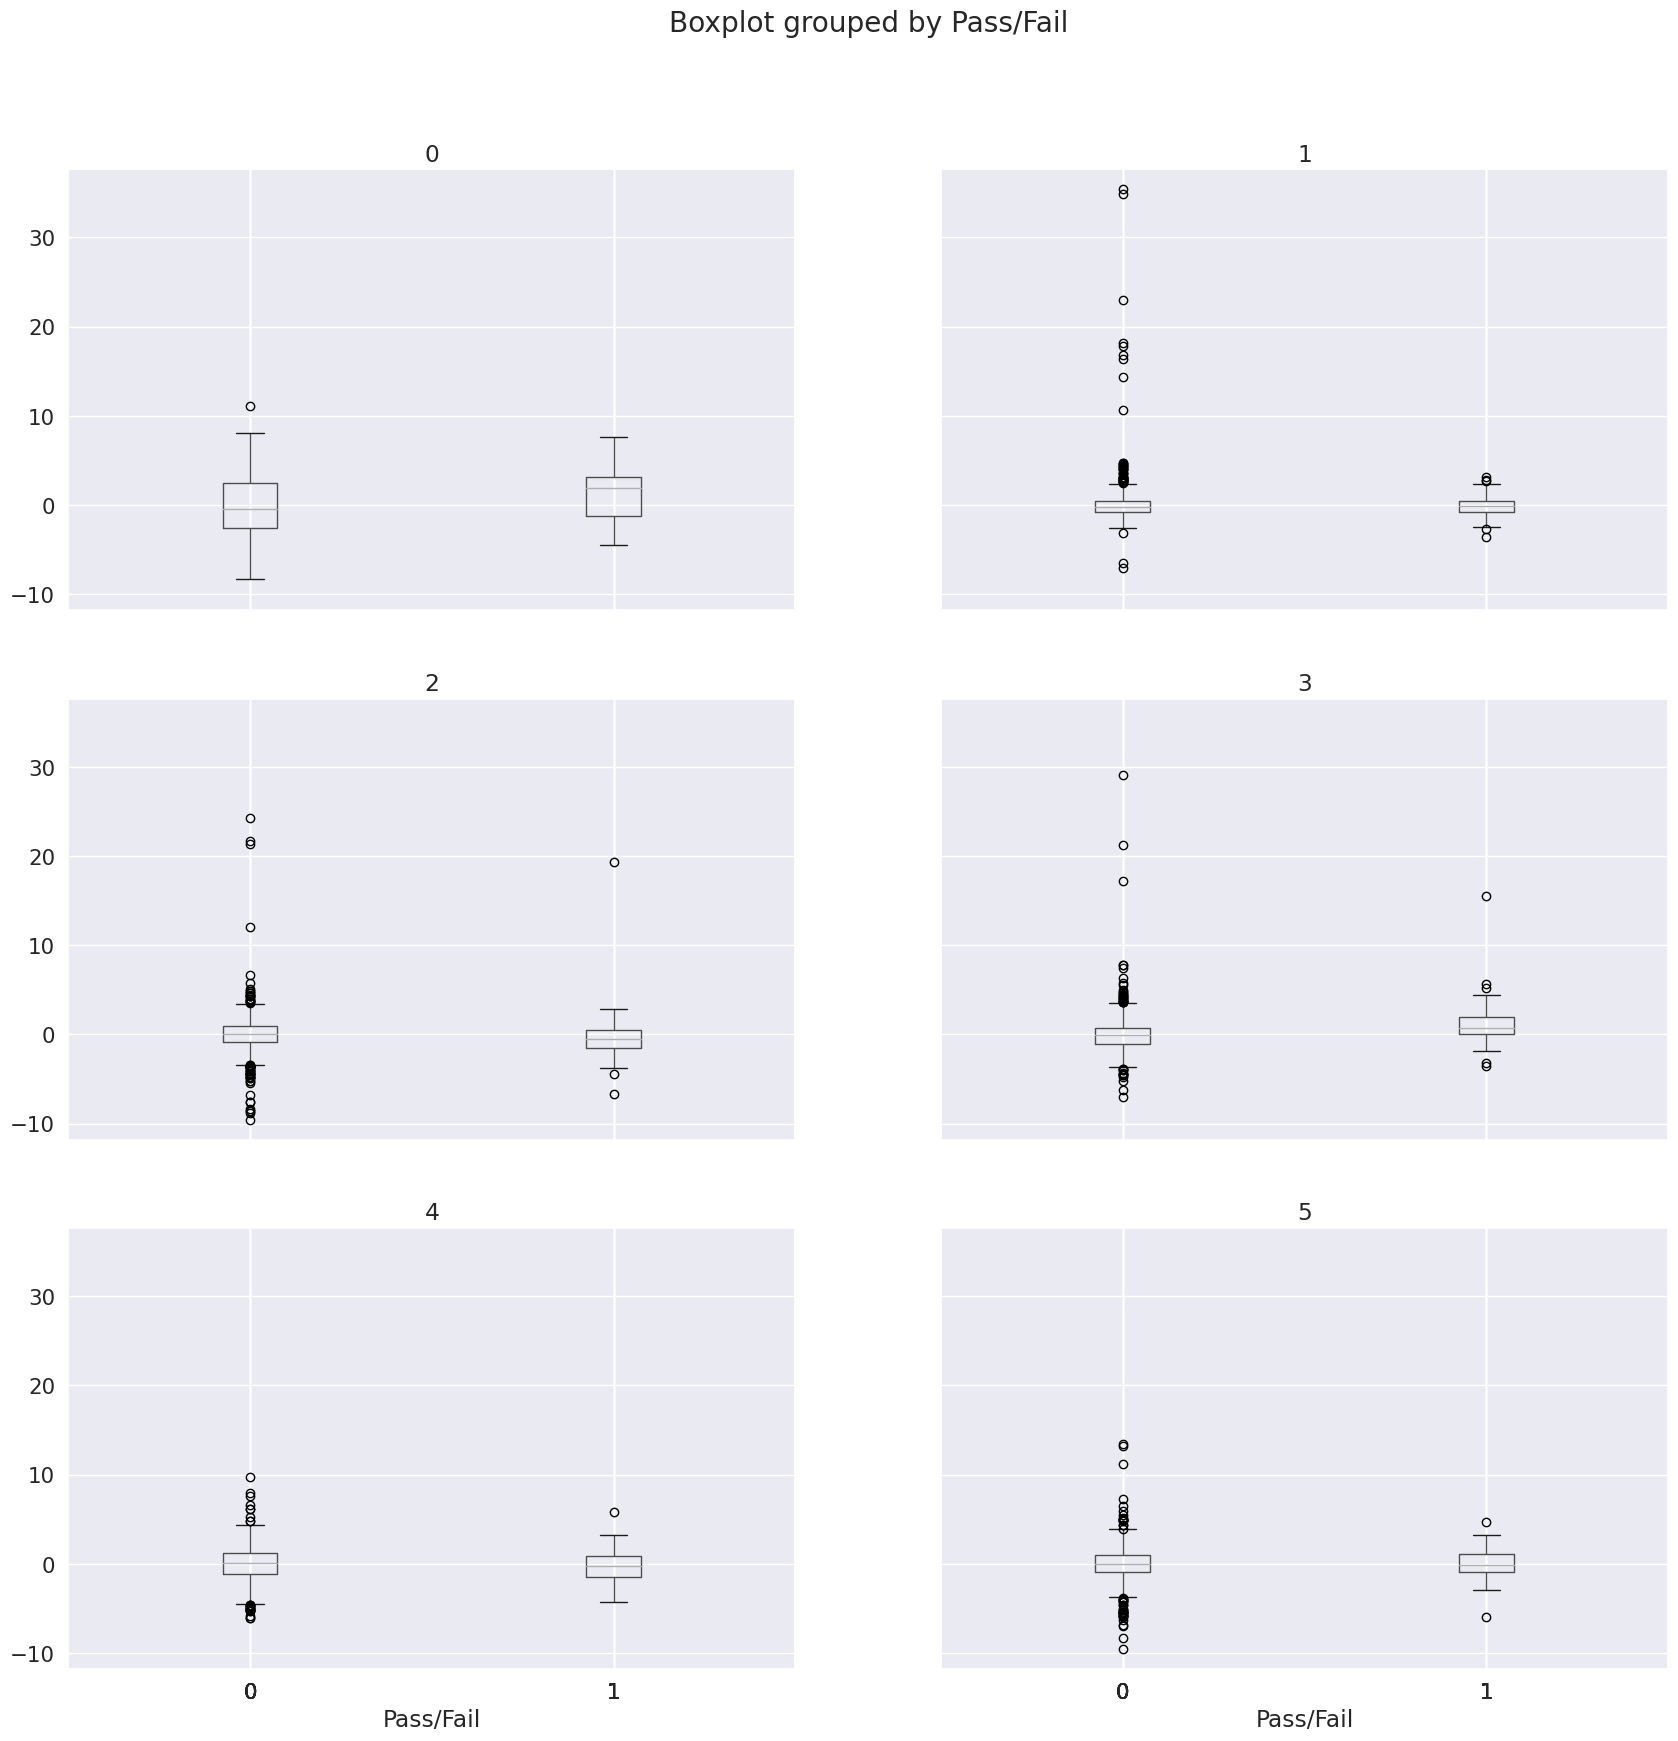

In [127]:
df_red4.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3],
                          df_red4.columns[4],
                          df_red4.columns[5]
                          ],
                by='Pass/Fail',
                figsize=(20, 20))

> 이상치 제거 적용 (Quantile, IQR 사용)

In [128]:
pd_data = df_red4.copy()

from scipy import stats

def outlier_removal_max(var):
  var = np.where(var > var.quantile(0.75) * stats.iqr(var), var.quantile(0.50), var)
  return var

def outlier_removal_min(var):
  var = np.where(var < var.quantile(0.25) - stats.iqr(var), var.quantile(0.50), var)
  return var

for column in pd_data:
  pd_data[column] = outlier_removal_max(pd_data[column])
  pd_data[column] = outlier_removal_min(pd_data[column])

array([[<Axes: title={'center': '0'}, xlabel='Pass/Fail'>,
        <Axes: title={'center': '1'}, xlabel='Pass/Fail'>],
       [<Axes: title={'center': '2'}, xlabel='Pass/Fail'>,
        <Axes: title={'center': '3'}, xlabel='Pass/Fail'>],
       [<Axes: title={'center': '4'}, xlabel='Pass/Fail'>,
        <Axes: title={'center': '5'}, xlabel='Pass/Fail'>]], dtype=object)

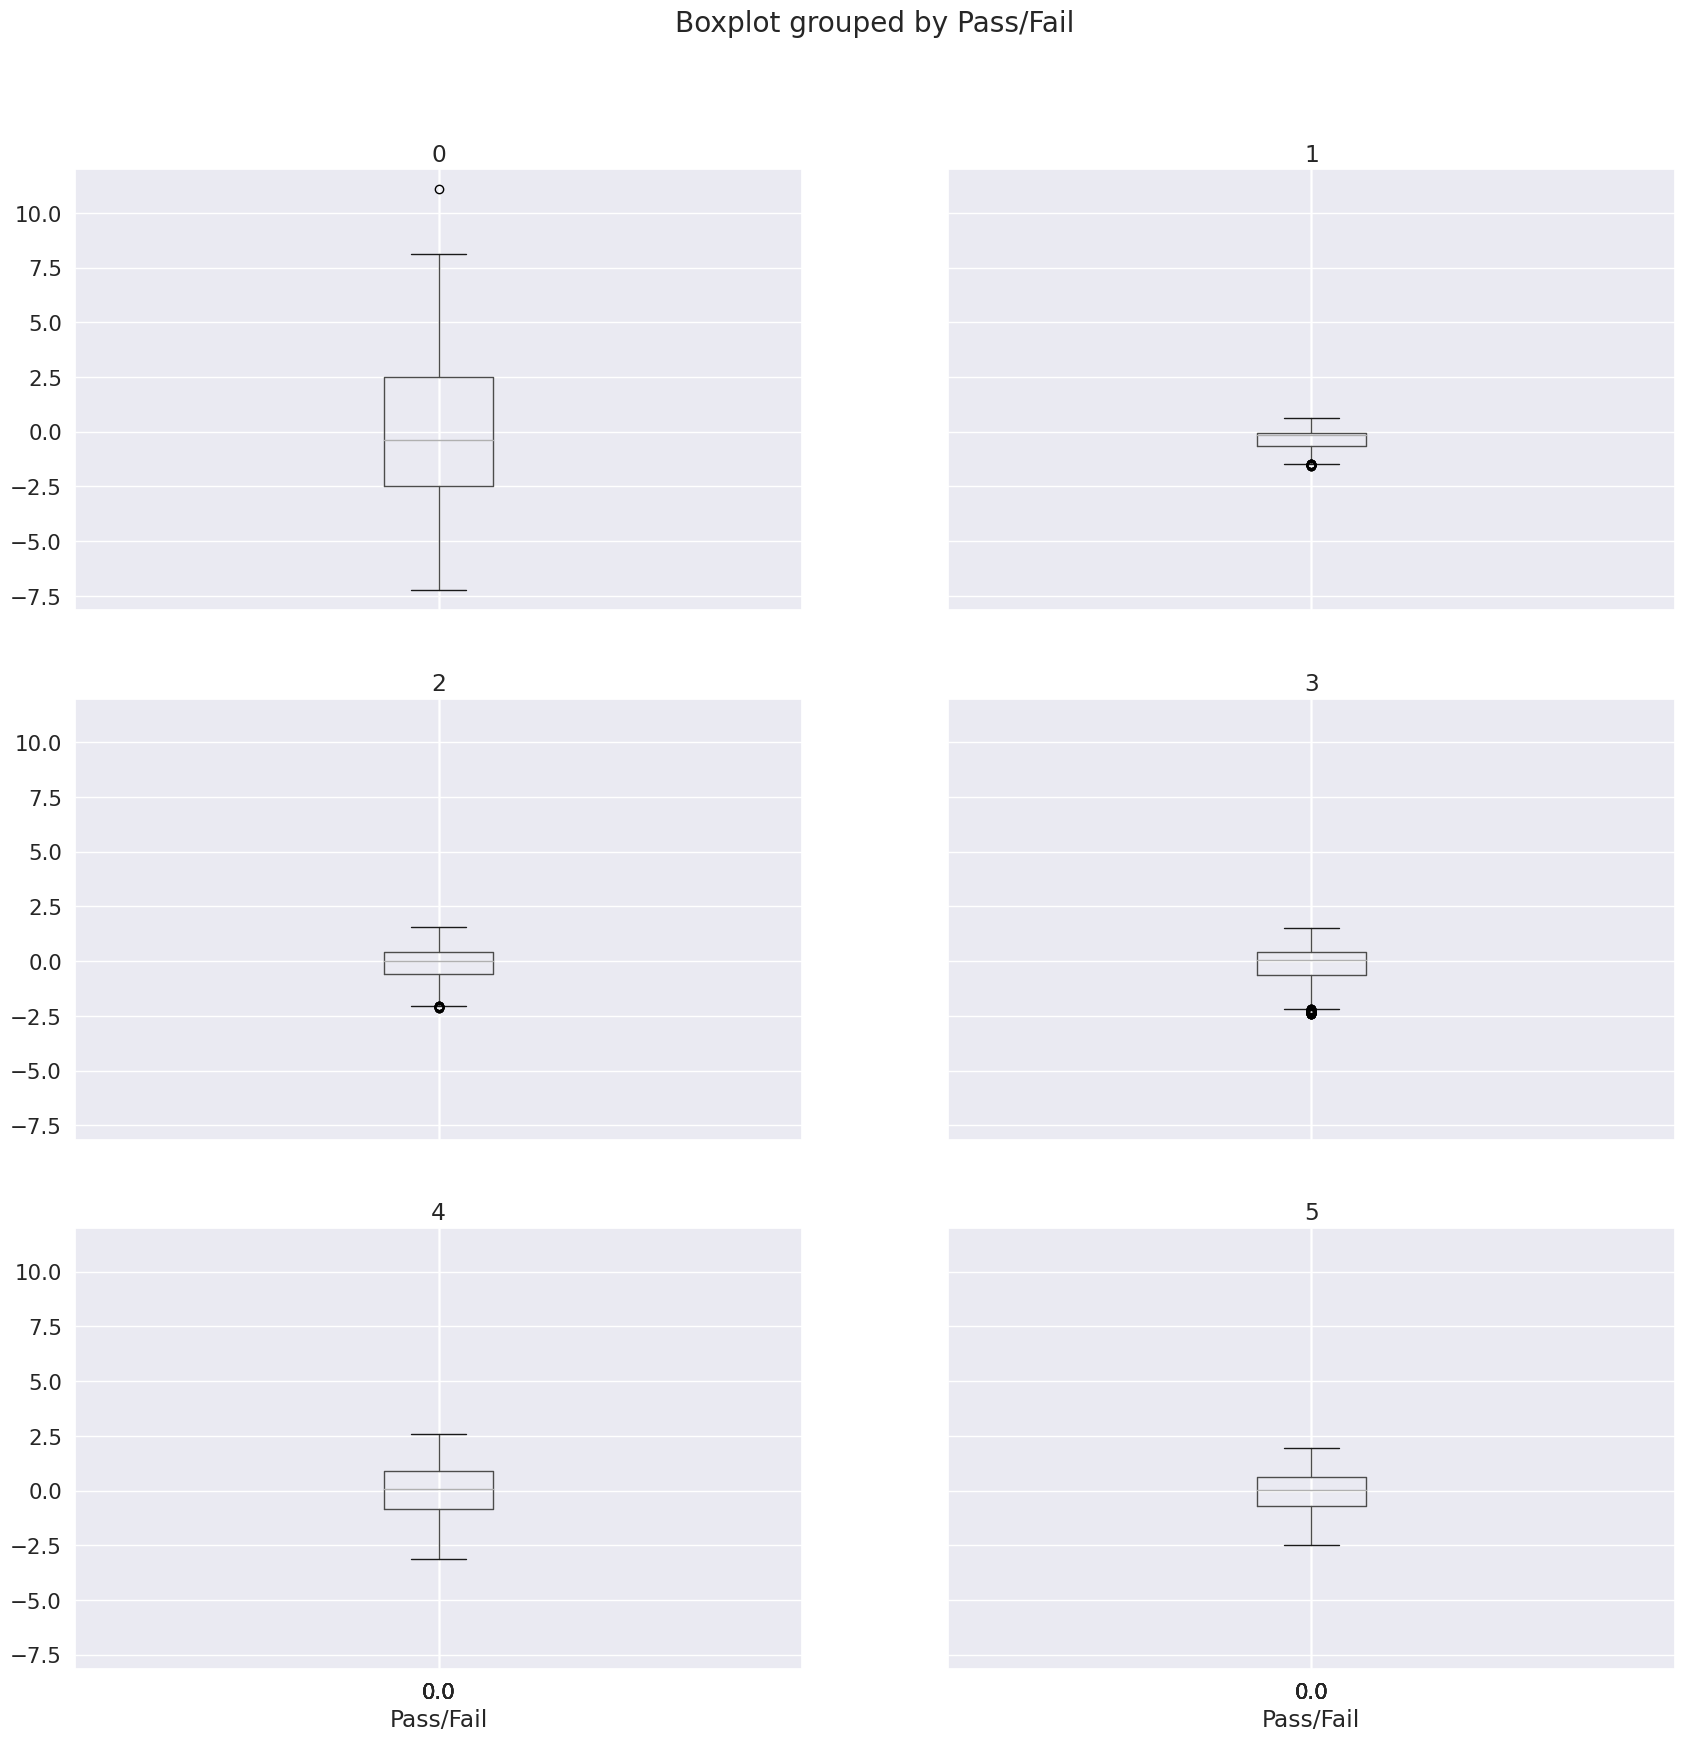

In [129]:
pd_data.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3],
                          df_red4.columns[4],
                          df_red4.columns[5]
                          ],
                by='Pass/Fail',
                figsize=(20, 20))